In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from src.experiment import get_fallacy_identification_df
from src.analysis import score_fallacy_identification, get_fallacy_identification_scores
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()


# Fallacy Identification

## Experiment 1

In [2]:
df = get_fallacy_identification_df()

[2024-10-17 12:49:14] Loaded existing fallacy identification dataframe from CSV.


In [3]:
score_fallacy_identification(df)

df.head()

,step,entity,fallacy,label,gpt_4o_response,gpt_4_response,gpt_4o_mini_response,sonnet_3_5_response,gemini_1_5_pro_response,gemini_1_5_flash_response,gpt_4_score,gpt_4o_score,gpt_4o_mini_score,sonnet_3_5_score,gemini_1_5_pro_score,gemini_1_5_flash_score
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,No.,No,No.,No,No,No,1,1,1,1,1,1
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,No.,No,No.,No,No,No,1,1,1,1,1,1
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,No.,No,No.,No,No,No,1,1,1,1,1,1
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,No.,No,No.,No,Yes,No,1,1,1,1,0,1
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,No.,No,No.,No,No,No,1,1,1,1,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   step                       4640 non-null   object
 1   entity                     4640 non-null   object
 2   fallacy                    4640 non-null   object
 3   label                      4640 non-null   int64 
 4   gpt_4o_response            4640 non-null   object
 5   gpt_4_response             4640 non-null   object
 6   gpt_4o_mini_response       4640 non-null   object
 7   sonnet_3_5_response        4640 non-null   object
 8   gemini_1_5_pro_response    4640 non-null   object
 9   gemini_1_5_flash_response  4640 non-null   object
 10  gpt_4_score                4640 non-null   Int64 
 11  gpt_4o_score               4640 non-null   Int64 
 12  gpt_4o_mini_score          4640 non-null   Int64 
 13  sonnet_3_5_score           4640 non-null   Int64 
 14  gemini_1

In [12]:
df_scores = get_fallacy_identification_scores(df)
df_scores = df_scores.sort_values('Score', ascending=False)
df_scores

,LLM,Score
0,GPT-4,89.8
4,Gemini 1.5 Pro,88.7
1,GPT-4o,88.4
2,GPT-4o Mini,86.9
3,Claude Sonnet 3.5,83.6
5,Gemini 1.5 Flash,83.2


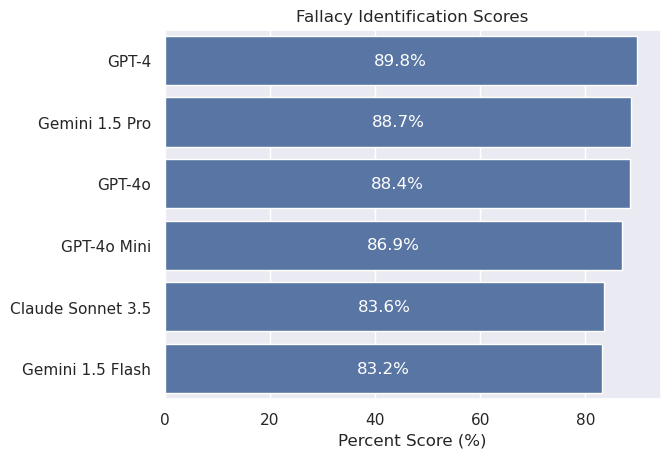

In [13]:
ax = sns.barplot(x='Score', y='LLM', data=df_scores)
plt.title('Fallacy Identification Scores')
plt.xlabel('Percent Score (%)')
plt.ylabel('')

# Add annotations inside the bars
for i, v in enumerate(df_scores['Score']):
    ax.text(v/2, i, f'{v:.1f}%',  ha='center', va='center', color='white')

plt.show()
